In [ ]:
# Step 1: Install dependencies
!pip install h5py numpy matplotlib tqdm

# Step 2: Mount Google Drive and set file path
from google.colab import drive
drive.mount('/content/drive')
h5_path = '/content/drive/MyDrive/Crypto/AES_PTv2_D1.h5'  # Update this path
# RAR file for the dataset : https://drive.google.com/file/d/1xDY3-xJ2GodaY2-qgsKm1_LrH7GxkIcr/view
# Step 3: Load MS2 Attack traces, plaintexts, and key
import h5py
import numpy as np

with h5py.File(h5_path, 'r') as f:
    ms2_traces = f['D1/MS2/Attack/Traces'][:]  # (100000, 1780)
    ms2_metadata = f['D1/MS2/Attack/MetaData'][:]  # structured array
    ms2_plaintexts = np.array([row['plaintext'] for row in ms2_metadata])
    ms2_keys = np.array([row['key'] for row in ms2_metadata])

print("MS2 Attack traces shape:", ms2_traces.shape)
print("MS2 Attack plaintexts shape:", ms2_plaintexts.shape)
print("MS2 Attack keys shape:", ms2_keys.shape)
print("First MS2 key:", [hex(x) for x in ms2_keys[0]])


Mounted at /content/drive
MS2 Attack traces shape: (100000, 1780)
MS2 Attack plaintexts shape: (100000, 16)
MS2 Attack keys shape: (100000, 16)
First MS2 key: ['0xca', '0xfe', '0xba', '0xbe', '0xde', '0xad', '0xbe', '0xef', '0x0', '0x1', '0x2', '0x3', '0x4', '0x5', '0x6', '0x7']


In [ ]:
# Step 4: Define AES S-box and second-order centered product function
AES_SBOX = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
], dtype=np.uint8)

def hamming_weight(x):
    return bin(x).count('1')

# Centered product for two points (second-order attack)
def centered_product(x, y):
    return (x - np.mean(x)) * (y - np.mean(y))


In [ ]:
# Step 5: Second-order CPA attack (centered product) for one key byte
from tqdm.notebook import trange

def second_order_cpa(traces, plaintexts, target_byte, poi1=700, poi2=900, num_traces=10000):
    # Use two points of interest (adjust as needed for your dataset!)
    x = traces[:num_traces, poi1]
    y = traces[:num_traces, poi2]
    cp = centered_product(x, y)

    plaintexts = plaintexts[:num_traces, target_byte]
    hypotheses = np.zeros((256, num_traces))
    for kg in range(256):
        sbox_out = AES_SBOX[plaintexts ^ kg]
        hypotheses[kg] = [hamming_weight(val) for val in sbox_out]

    hyp_norm = (hypotheses - hypotheses.mean(axis=1, keepdims=True)) / hypotheses.std(axis=1, keepdims=True)
    cp_norm = (cp - np.mean(cp)) / np.std(cp)

    # Pearson correlation for each key guess
    corrs = np.array([np.corrcoef(hyp_norm[kg], cp_norm)[0,1] for kg in range(256)])
    best_guess = np.argmax(np.abs(corrs))
    return best_guess, corrs


In [ ]:
# Example: scan POIs for best correlation on byte 0
best_corr = 0
best_poi = (0, 0)
for poi1 in range(200, 1000, 20):
    for poi2 in range(poi1+1, 1000, 20):
        kguess, corrs = second_order_cpa(ms2_traces, ms2_plaintexts, 0, poi1, poi2, num_traces=10000)
        if np.max(np.abs(corrs)) > best_corr:
            best_corr = np.max(np.abs(corrs))
            best_poi = (poi1, poi2)
print("Best POIs:", best_poi, "Best Corr:", best_corr)


KeyboardInterrupt: 

Recovered: 0x1d | Actual: 0xca | Match: False


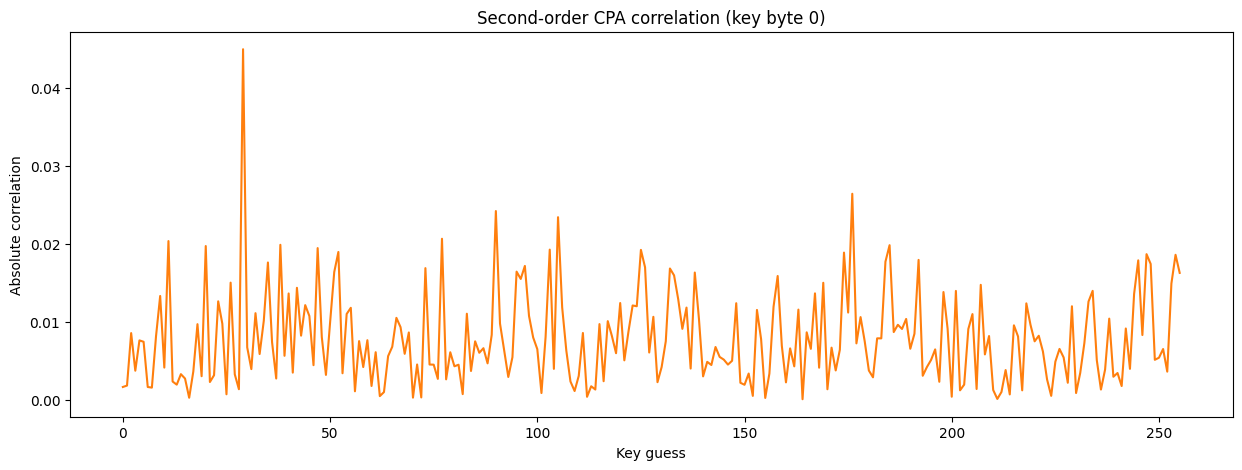

In [ ]:
# Step 6: Try second-order attack on first key byte
best_byte, corrs = second_order_cpa(ms2_traces, ms2_plaintexts, 0, poi1=600, poi2=781, num_traces=10000)
print(f"Recovered: 0x{best_byte:02x} | Actual: 0x{ms2_keys[0][0]:02x} | Match: {best_byte == ms2_keys[0][0]}")

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.plot(np.abs(corrs[best_byte]), label=f'Guess: 0x{best_byte:02x}')
plt.plot(np.abs(corrs[ms2_keys[0][0]]), 'r--', label=f'Actual: 0x{ms2_keys[0][0]:02x}')
plt.plot(np.abs(corrs))
plt.title("Second-order CPA correlation (key byte 0)")
plt.xlabel("Key guess")
plt.ylabel("Absolute correlation")
plt.show()


In [ ]:
# Step 7: Full key recovery for MS2 (may require more traces and tuning POIs)
recovered_key = []
for byte_idx in trange(16, desc='Key Recovery'):
    kguess, _ = second_order_cpa(ms2_traces, ms2_plaintexts, byte_idx, poi1=700, poi2=900, num_traces=50000)
    recovered_key.append(kguess)
    print(f"Recovered byte {byte_idx}: 0x{kguess:02x} | Actual: 0x{ms2_keys[0][byte_idx]:02x}")

print("\nRecovered Key:", bytes(recovered_key).hex())
print("Actual Key:   ", bytes(ms2_keys[0]).hex())
print("Full Match:   ", bytes(recovered_key) == bytes(ms2_keys[0]))


Key Recovery:   0%|          | 0/16 [00:00<?, ?it/s]

Recovered byte 0: 0xa8 | Actual: 0xca
Recovered byte 1: 0x9e | Actual: 0xfe
Recovered byte 2: 0x7c | Actual: 0xba
Recovered byte 3: 0x80 | Actual: 0xbe
Recovered byte 4: 0x08 | Actual: 0xde
Recovered byte 5: 0x65 | Actual: 0xad
Recovered byte 6: 0xb9 | Actual: 0xbe
Recovered byte 7: 0xb3 | Actual: 0xef
Recovered byte 8: 0x37 | Actual: 0x00
Recovered byte 9: 0xfd | Actual: 0x01
Recovered byte 10: 0xa5 | Actual: 0x02
Recovered byte 11: 0x8d | Actual: 0x03
Recovered byte 12: 0xfa | Actual: 0x04
Recovered byte 13: 0x25 | Actual: 0x05
Recovered byte 14: 0x9e | Actual: 0x06
Recovered byte 15: 0x3f | Actual: 0x07

Recovered Key: a89e7c800865b9b337fda58dfa259e3f
Actual Key:    cafebabedeadbeef0001020304050607
Full Match:    False
